# Initial Setup 

In [71]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from bdi_predict.ml_logic.sequence_gen import WindowGenerator
from tensorflow.keras import layers
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping

NameError: name 'train_df' is not defined

In [72]:
df = pd.read_csv("../raw_data/data/BDI/log_diff_BDI_daily.csv")
df.head(2)

,Unnamed: 0,Date,Price,abs_price,log_price,log_diff
0,0,1995-01-03,1964.0,NaN,3.293141,NaN
1,1,1995-01-04,1961.0,-3.0,3.292478,-0.000664


In [37]:
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df = df[df.index != "1995-01-03"]
df.drop(columns="Unnamed: 0", inplace=True)
df.head(2)

,Price,abs_price,log_price,log_diff
Date,,,,
1995-01-04,1961.0,-3.0,3.292478,-0.000664
1995-01-05,1967.0,6.0,3.293804,0.001327


In [38]:
df["log_diff_100"] = df["log_diff"]*100
df["log_diff_1000"] = df["log_diff"]*1000
df["log_diff_10000"] = df["log_diff"]*10000
df.head(3)

,Price,abs_price,log_price,log_diff,log_diff_100,log_diff_1000,log_diff_10000
Date,,,,,,,
1995-01-04,1961.0,-3.0,3.292478,-0.000664,-0.066389,-0.663890,-6.638898
1995-01-05,1967.0,6.0,3.293804,0.001327,0.132677,1.326766,13.267663
1995-01-06,1983.0,16.0,3.297323,0.003518,0.351835,3.518354,35.183543


<AxesSubplot: xlabel='Date'>

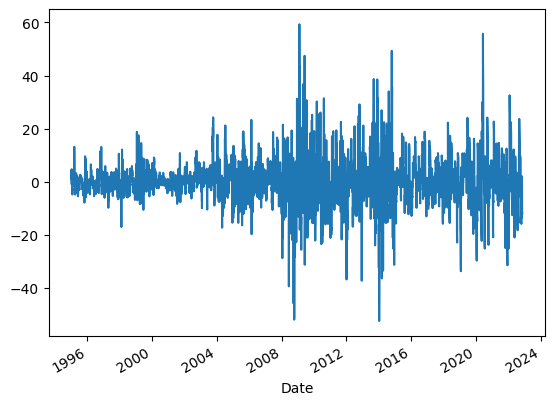

In [39]:
df["log_diff_1000"].plot()

<AxesSubplot: xlabel='Date'>

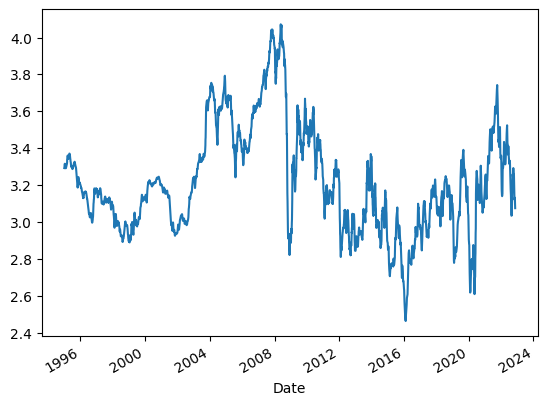

In [40]:
df["log_price"].plot()

<AxesSubplot: xlabel='Date'>

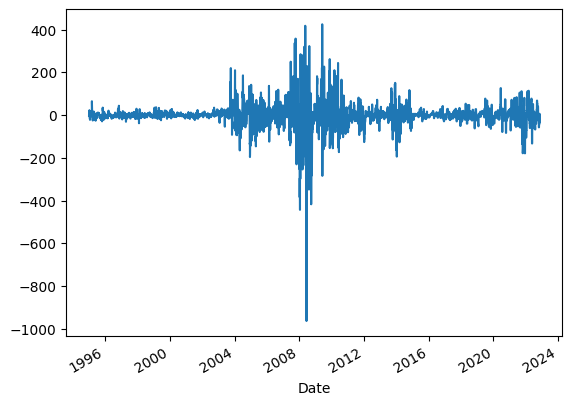

In [41]:
df["abs_price"].plot()

<AxesSubplot: xlabel='Date'>

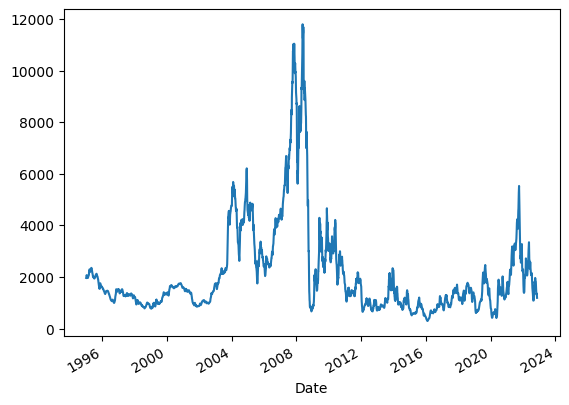

In [42]:
df["Price"].plot()

REMINDER: New target is: $$log(𝑦𝑡)−log(𝑦𝑡−1)=log(𝑦𝑡/𝑦𝑡−1)$$

# Using our bespoke window/sequence generator to generate sequences:

1. Generate sequences that predict the log difference a day ahead with input length of 10 days (two weeks) 
2. generate sequences that predict the log differences a day ahead with input length of 20 days (a month)

In [43]:
input_length = len(df)

In [44]:
def train_test_split(df:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple:
    '''
    Returns a train dataframe and a test dataframe (df_train, df_test)
    from which one can sample (X,y) sequences using TimeseriesGenerator.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    
    # TRAIN SET

    last_train_idx = round(train_test_ratio * len(df))
    df_train = df.iloc[0:last_train_idx, :]

    # TEST SET
 
    first_test_idx = last_train_idx - input_length
    df_test = df.iloc[first_test_idx:, :]

    return (df_train, df_test)

In [45]:
df_train, df_test = train_test_split(df=df, train_test_ratio=0.8, input_length=input_length)

In [46]:
X_train = df_train[["Price"]]
y_train = df_train["log_diff_100"]

X_test  = df_test[["Price"]]
y_test = df_test["log_diff_100"]

In [47]:
#Feature Scaling

scaler_X = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.fit_transform(X_test)



In [48]:
X_train_scaled[:2]

array([[0.14519214],
       [0.14571379]])

In [49]:
y_train[:2]

Date
1995-01-04   -0.066389
1995-01-05    0.132677
Name: log_diff_100, dtype: float64

In [50]:
# scaler_y = MinMaxScaler()

# y_train_scaled = scaler_y.fit_transform(y_train)
# y_test_scaled = scaler_y.fit_transform(y_test)

In [51]:
generator = TimeseriesGenerator(X_train_scaled, y_train, length=10, batch_size=4, sampling_rate=1, stride=1)

In [52]:
generator_val = TimeseriesGenerator(X_test_scaled, y_test, length=10, batch_size=4, sampling_rate=1, stride=1)

In [53]:
len(generator)

1411

In [54]:
for X, y in generator:
    print(X.shape, y.shape)
    print(X[0], y[0])
    #listy = [float(X[0][i]) for i in range(len(X[0]))]
    #print(listy)
    break

(4, 10, 1) (4,)
[[0.14519214]
 [0.14571379]
 [0.14710485]
 [0.14806121]
 [0.14988698]
 [0.15023474]
 [0.15188663]
 [0.15379934]
 [0.15440793]
 [0.15475569]] 0.0


# Using TimseriesGenerator to create sequences:

# The Model

In [55]:
# Learning Rate Scheduler: 

lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

In [58]:
#Optimizers

rmsprop = RMSprop(learning_rate=lr_schedule) #or 0.001 for inital test
adam = Adam(learning_rate=lr_schedule)

In [59]:
#Early Stopping Criterion:

es = EarlyStopping(monitor="val_mae", patience=100, restore_best_weights=True)

In [62]:
#Initializing and compiling model:

def init_model():
    
    model = Sequential()

    #LSTM layers
    model.add(layers.LSTM(400, activation="tanh", input_shape=(10,1), return_sequences=False))

    #Dense layers
    model.add(layers.Dense(150, activation="relu"))
    model.add(layers.Dense(1, activation="linear"))

    #compiling model
    model.compile(loss="mse", optimizer=rmsprop, metrics="mae")
    
    return model

# Training and Testing

In [63]:
X_train_scaled[:2]

array([[0.14519214],
       [0.14571379]])

In [64]:
y_train[:5]

Date
1995-01-04   -0.066389
1995-01-05    0.132677
1995-01-06    0.351835
1995-01-09    0.240244
1995-01-10    0.454990
Name: log_diff_100, dtype: float64

In [65]:
#Instantiating model

model = init_model()

#TRAINING THE MODEL:

history = model.fit(
    generator, epochs=30, validation_data=generator_val, shuffle=False, callbacks=es
)

Epoch 1/30


2022-11-27 14:43:56.156545: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1411/1411 [==============================] - 19s 12ms/step - loss: 0.5932 - mae: 0.4955 - val_loss: 1.0749 - val_mae: 0.7958
Epoch 2/30
1411/1411 [==============================] - 16s 11ms/step - loss: 0.5366 - mae: 0.4771 - val_loss: 2.0379 - val_mae: 1.1897
Epoch 3/30
1411/1411 [==============================] - 19s 14ms/step - loss: 0.5224 - mae: 0.4698 - val_loss: 2.7652 - val_mae: 1.4345
Epoch 4/30
1411/1411 [==============================] - 17s 12ms/step - loss: 0.5084 - mae: 0.4618 - val_loss: 2.8913 - val_mae: 1.4831
Epoch 5/30
1411/1411 [==============================] - 16s 11ms/step - loss: 0.4934 - mae: 0.4561 - val_loss: 2.6133 - val_mae: 1.4029
Epoch 6/30
1411/1411 [==============================] - 16s 12ms/step - loss: 0.4914 - mae: 0.4564 - val_loss: 3.4647 - val_mae: 1.6479
Epoch 7/30
1411/1411 [==============================] - 17s 12ms/step - loss: 0.4859 - mae: 0.4531 - val_loss: 2.7650 - val_mae: 1.4493
Epoch 8/30
1411/1411 [==============================] - 18s

In [66]:
#Model layers & params overview:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 400)               643200    
                                                                 
 dense (Dense)               (None, 150)               60150     
                                                                 
 dense_1 (Dense)             (None, 1)                 151       
                                                                 
Total params: 703,501
Trainable params: 703,501
Non-trainable params: 0
_________________________________________________________________


array([<AxesSubplot: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <AxesSubplot: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

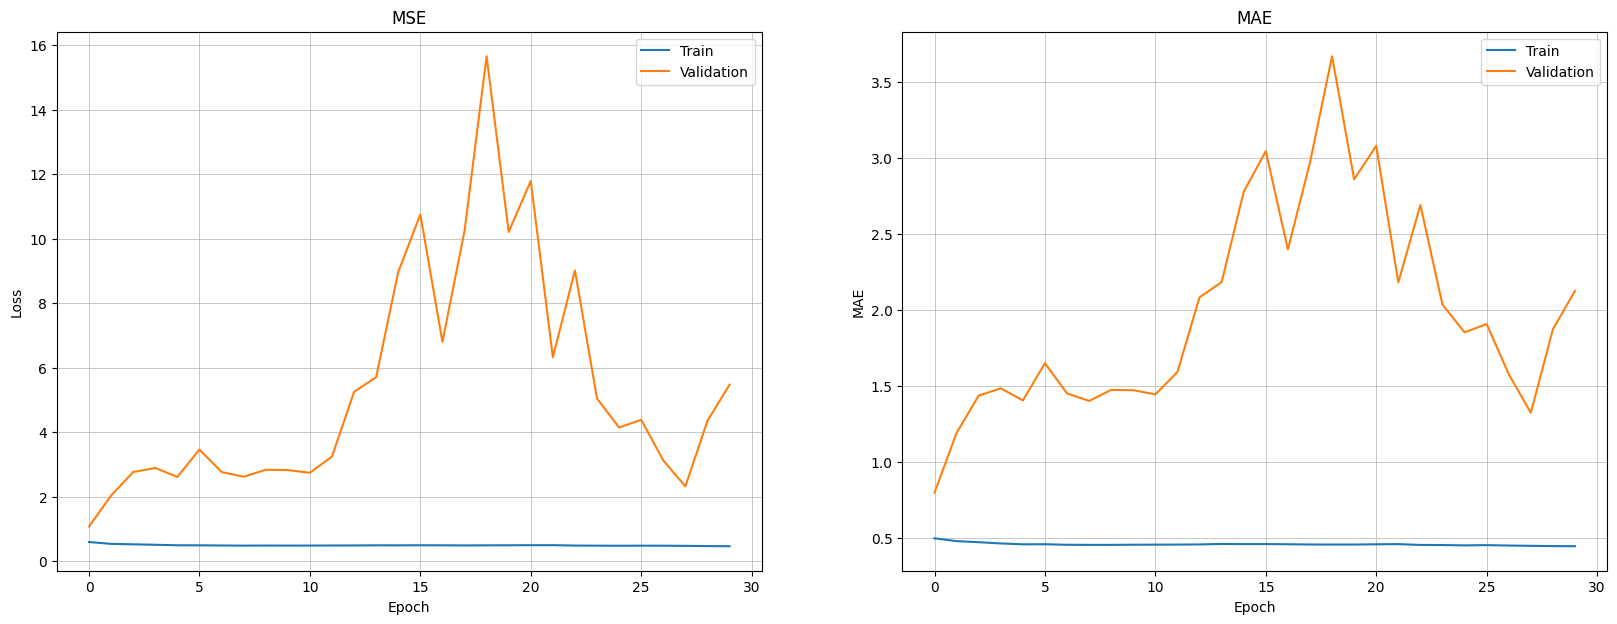

In [69]:
# Learning Curves:
plot_history(history)

# Reinterpreting the y_pred to an actual absolute BDI value

In [135]:
for X, y in generator:
    print(X.shape, y.shape)
    print(X[0], y[0])
    listx = [float(X[0][i]) for i in range(len(X[0]))]
    print(listx)
    

(4, 10, 1) (4,)
[[0.14519214]
 [0.14571379]
 [0.14710485]
 [0.14806121]
 [0.14988698]
 [0.15023474]
 [0.15188663]
 [0.15379934]
 [0.15440793]
 [0.15475569]] 0.0
[0.1451921404973048, 0.14571378890627718, 0.14710485133020343, 0.14806120674665274, 0.149886976178056, 0.15023474178403756, 0.15188662841245001, 0.15379933924534864, 0.15440792905581638, 0.15475569466179795]
(4, 10, 1) (4,)
[[0.14988698]
 [0.15023474]
 [0.15188663]
 [0.15379934]
 [0.15440793]
 [0.15475569]
 [0.15475569]
 [0.15466875]
 [0.1537124 ]
 [0.15240828]] -0.25571878507935003
[0.149886976178056, 0.15023474178403756, 0.15188662841245001, 0.15379933924534864, 0.15440792905581638, 0.15475569466179795, 0.15475569466179795, 0.15466875326030255, 0.15371239784385324, 0.15240827682142236]
(4, 10, 1) (4,)
[[0.15440793]
 [0.15475569]
 [0.15475569]
 [0.15466875]
 [0.1537124 ]
 [0.15240828]
 [0.15136498]
 [0.1501478 ]
 [0.14823509]
 [0.14710485]] -0.13160448916305
[0.15440792905581638, 0.15475569466179795, 0.15475569466179795, 0.154

In [136]:
X_pred = [[0.1451921404973048, 0.14571378890627718, 0.14710485133020343, 0.14806120674665274, 0.149886976178056, 0.15023474178403756, 0.15188662841245001, 0.15379933924534864, 0.15440792905581638, 0.15475569466179795]]

In [276]:
y_pred = model.predict(X_pred)

In [277]:
y_pred 
#log_diff_100

array([[-3.7788198]], dtype=float32)

In [278]:
y_pred = np.array(-1.3567)

In [279]:
y_pred_100 = y_pred/100
y_pred_100
#log_diff

-0.013567000000000001

In [280]:
df["log_price"][10]

3.3161800988934527

In [281]:
y_pred_log_price = y_pred_100 + df["log_price"][10]
y_pred_log_price

3.3026130988934526

In [282]:
y_pred_abs_price = 10**y_pred_log_price
y_pred_abs_price

2007.3037636550032

In [283]:
df.iloc[:20]

,Price,abs_price,log_price,log_diff,log_diff_1000,log_diff_10000,log_diff_100
Date,,,,,,,
1995-01-04,1961.0,-3.0,3.292478,-0.000664,-0.663890,-6.638898,-0.066389
1995-01-05,1967.0,6.0,3.293804,0.001327,1.326766,13.267663,0.132677
1995-01-06,1983.0,16.0,3.297323,0.003518,3.518354,35.183543,0.351835
1995-01-09,1994.0,11.0,3.299725,0.002402,2.402440,24.024398,0.240244
1995-01-10,2015.0,21.0,3.304275,0.004550,4.549897,45.498965,0.454990
1995-01-11,2019.0,4.0,3.305136,0.000861,0.861268,8.612685,0.086127
1995-01-12,2038.0,19.0,3.309204,0.004068,4.067861,40.678607,0.406786
1995-01-13,2060.0,22.0,3.313867,0.004663,4.663041,46.630407,0.466304
1995-01-16,2067.0,7.0,3.315340,0.001473,1.473256,14.732563,0.147326


In [ ]:
#Saving model 
model.save("univariate_model_log_diff")

In [263]:
X_pred_3 = pd.DataFrame(df["Price"].iloc[160:170])

In [264]:
X_pred_3 = scaler_X.transform(X_pred_3)
X_pred_3 = X_pred_3.reshape((1, 10))
X_pred_3

array([[0.33365892, 0.33444032, 0.33463567, 0.33502637, 0.33424497,
        0.33248681, 0.33111936, 0.32994726, 0.3277984 , 0.32584489]])

In [265]:
df.iloc[160:171]

,Price,abs_price,log_price,log_diff,log_diff_1000,log_diff_10000,log_diff_100
Date,,,,,,,
1995-08-22,2115.0,5.0,3.325310,0.001028,1.027916,10.279164,0.102792
1995-08-23,2119.0,4.0,3.326131,0.000821,0.820585,8.205850,0.082058
1995-08-24,2120.0,1.0,3.326336,0.000205,0.204904,2.049042,0.020490
1995-08-25,2122.0,2.0,3.326745,0.000410,0.409519,4.095186,0.040952
1995-08-29,2118.0,-4.0,3.325926,-0.000819,-0.819424,-8.194238,-0.081942
1995-08-30,2109.0,-9.0,3.324077,-0.001849,-1.849376,-18.493760,-0.184938
1995-08-31,2102.0,-7.0,3.322633,-0.001444,-1.443868,-14.438680,-0.144387
1995-09-01,2096.0,-6.0,3.321391,-0.001241,-1.241433,-12.414334,-0.124143
1995-09-04,2085.0,-11.0,3.319106,-0.002285,-2.285219,-22.852190,-0.228522


In [21]:
y_pred_2 = model.predict(X_pred_3)

NameError: name 'model' is not defined

In [1]:
y_pred_2

NameError: name 'y_pred_2' is not defined

In [268]:
y_pred_2_100 = y_pred_2/100
#log_diff

In [269]:
X_prev = np.log10(2216.0)
y_pred_log_price_2 = y_pred_2_100 + X_prev
y_pred_log_price_2

array([[3.331073]], dtype=float32)

In [270]:
10**y_pred_log_price_2

array([[2143.251]], dtype=float32)

In [29]:
df.iloc[40:80]

,Price,abs_price,log_price,log_diff,log_diff_100,log_diff_1000,log_diff_10000
Date,,,,,,,
1995-03-01,2044.0,6.0,3.310481,0.001277,0.127671,1.276712,12.767118
1995-03-02,2052.0,8.0,3.312177,0.001696,0.169646,1.696465,16.964650
1995-03-03,2066.0,14.0,3.315130,0.002953,0.295296,2.952961,29.529607
1995-03-06,2072.0,6.0,3.316390,0.001259,0.125943,1.259434,12.594339
1995-03-07,2083.0,11.0,3.318689,0.002300,0.229952,2.299519,22.995189
1995-03-08,2090.0,7.0,3.320146,0.001457,0.145702,1.457016,14.570162
1995-03-09,2111.0,21.0,3.324488,0.004342,0.434195,4.341947,43.419472
1995-03-10,2176.0,65.0,3.337659,0.013171,1.317066,13.170658,131.706577
1995-03-13,2196.0,20.0,3.341632,0.003973,0.397344,3.973445,39.734448


# Learning Curves viz code:

In [68]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # Loss:MSE
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # Metrics:MAE
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax